In [4]:
from API import get_data_from_api
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import plotly.express as px
plt.rcParams['figure.figsize'] = 16,9
plt.rcParams['font.size'] = 18

### Wizualizacja użycia systemu wypożyczeń w skali jednego miasta

In [5]:
cityname = "Karlsruhe"

#### Funkcja wyznaczająca statystyki wypożyczeń w czasie

Pole `valid` oznacza czy w wynikowej ramce danych dany wiersz powinien być brany pod uwagę w analizie. Jeśli porównywane rekordy pochodzą z różnych stacji bądź czas między ich pobraniem wyniósł więcej niż 10 minut, pole przyjmuje wartość `False`

In [6]:
def calculate_usage(x):
    s1 = set(x['bike_numbers'])
    s2 = set(x['bike_numbers_shifted'])
    time_diff_validation = (x['timestamp'] - x['timestamp_shifted']) < pd.Timedelta(minutes=10)
    return_dict = {'timestamp_start': x['timestamp_shifted'],
                   'timestamp_end': x['timestamp'],
                   'uid': x['uid'],
                   'lat': x['lat'],
                   'lng': x['lng']}
    if x['uid'] == x['uid_shifted']:
        return_dict.update({'returned': len(s1-s2), 'collected': len(s2-s1), 'valid': time_diff_validation})
    else:
        return_dict.update({'returned': -1, 'collected': -1, 'valid': False})
    return return_dict

In [7]:
def add_timestamp_to_dict(result):
    timestamp = result.get('timestamp', pd.to_datetime('1970-01-01 00:00'))
    result_list = result['countries']['cities']['places']
    for d in result_list:
        d['timestamp'] = timestamp
    return result_list

In [8]:
client = get_data_from_api.create_mong_client()

In [9]:
db = client['bda']

In [10]:
db.bikes.count_documents({})

3883

In [11]:
record = db.bikes.find_one()

In [12]:
list(map(lambda x: (x['name'], len(x['cities'])), record['countries']))

[('nextbike Austria', 0),
 ('nextbike New Zealand', 2),
 ('nextbike Niederösterreich Austria', 17),
 ('nextbike Switzerland', 17),
 ('nextbike LV', 1),
 ('WRM nextbike Poland', 1),
 ('metropolradruhr Germany', 10),
 ('nextbike Cyprus', 3),
 ('PRM Poznan Poland', 0),
 ('Opole Bike Poland', 0),
 ('VETURILO Poland', 0),
 ('nextbike Stirling', 1),
 ('nextbike Croatia', 3),
 ('Demoland', 6),
 ('Stadtrad Innsbruck Austria', 1),
 ('Nextbike Poland ', 0),
 ('KVV.nextbike', 7),
 ('BIKER Białystok Poland', 1),
 ('BelfastBikes', 1),
 ('KRM Konstanciński Poland', 0),
 ('Grad Šibenik (Croatia)', 1),
 ('LRM Lublin Poland', 3),
 ('GRM Grodzisk Poland', 0),
 ('VRNnextbike', 22),
 ('nextbike Prostejov', 1),
 ('KVB Rad Germany', 1),
 ('nextbike (Ukraine)', 6),
 ('nextbike business Germany', 0),
 ('Katowice Bike Poland', 0),
 ('nextbike Malta', 1),
 ('Grad Karlovac (Croatia)', 1),
 ('Grad Slavonski Brod (Croatia)', 1),
 ('Heraeus Hanau', 1),
 ('nextbike Romania', 1),
 ('Santander Cycles - Milton Keynes',

In [13]:
n_rows = 3859

In [14]:
r = db.bikes.aggregate([
      {"$unwind":"$countries"},
      {"$unwind":"$countries.cities"}, 
      {"$match":
       {"countries.cities.name":cityname}
      },
      {'$limit': n_rows}
])

In [15]:
df = pd.concat([pd.DataFrame(add_timestamp_to_dict(r_t)) for r_t in r])

In [16]:
stations = df.uid.value_counts()[df.uid.value_counts()==n_rows].index

In [17]:
df = df.loc[df['uid'].isin(stations)]

In [18]:
df = df.sort_values(['uid', 'timestamp']).reset_index(drop=True)
df['bike_numbers_shifted'] = df['bike_numbers'].shift(1).combine(df['bike_numbers'], (lambda x, y: x if isinstance(x, list) else y))
df['timestamp_shifted'] = df['timestamp'].shift(1, fill_value=pd.to_datetime('1970-01-01 00:00'))
df['uid_shifted'] = df['uid'].shift(1, fill_value=-1)

In [19]:
x = df.apply(calculate_usage, axis=1, result_type='expand')

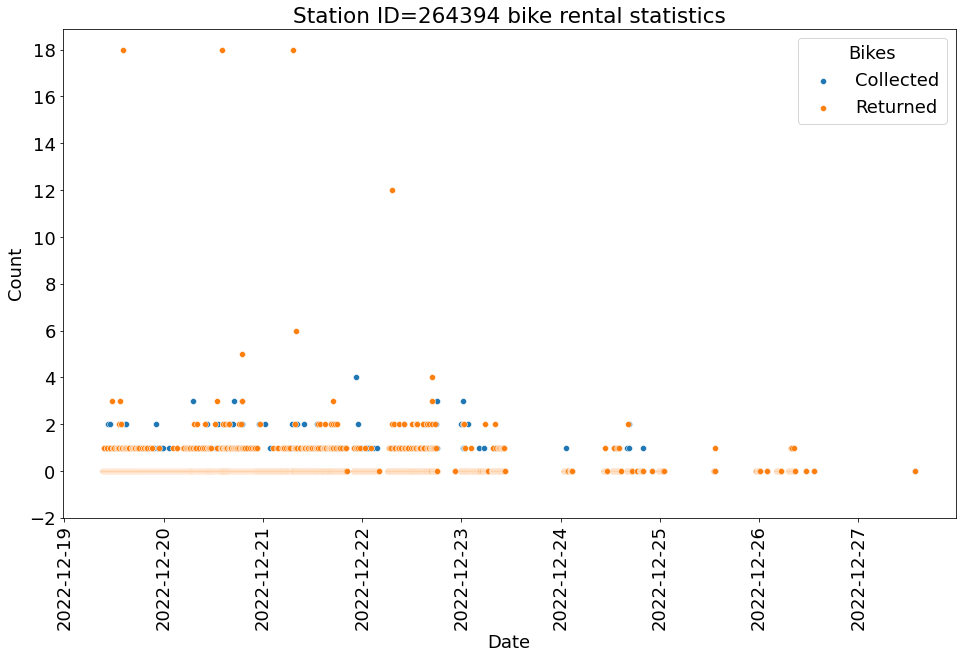

In [20]:
station_uid = 264394
station_df = x.loc[(x.uid==station_uid) & x.valid,]
fig, ax = plt.subplots()
sns.scatterplot(x = 'timestamp_end', y='collected', data = station_df, label='Collected', ax=ax)
sns.scatterplot(x = 'timestamp_end', y='returned', data = station_df, label='Returned', ax=ax)
l = plt.legend()
l.set_title("Bikes")
plt.yticks(np.arange(ax.get_yticks().min().round(), ax.get_yticks().max(), 2))
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title(f'Station ID={station_uid} bike rental statistics')
plt.show()
plt.show()

In [21]:
station_df.returned.max()

18

In [22]:
agg_x = x.loc[x.valid, :].groupby('timestamp_end').aggregate({'returned': 'sum', 'collected': 'sum'})

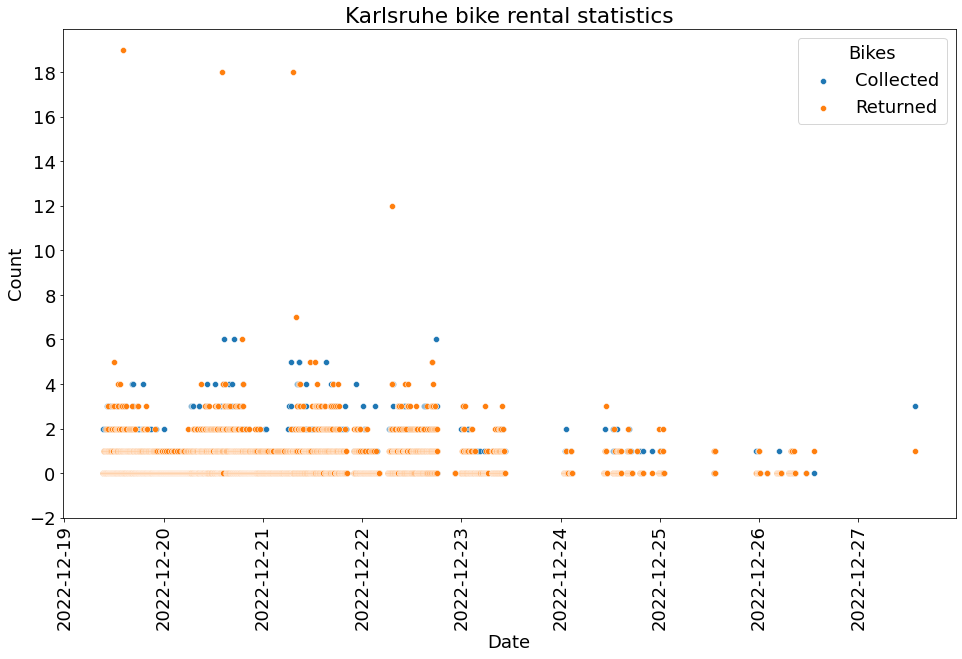

In [23]:
fig, ax = plt.subplots()
sns.scatterplot(x = 'timestamp_end', y='collected', data = agg_x, label='Collected', ax=ax)
sns.scatterplot(x = 'timestamp_end', y='returned', data = agg_x, label='Returned', ax=ax)
l = plt.legend()
l.set_title("Bikes")
plt.yticks(np.arange(ax.get_yticks().min().round(), ax.get_yticks().max(), 2))
plt.ylabel('Count')
plt.xlabel('Date')
plt.xticks(rotation=90)
plt.title(f'{cityname} bike rental statistics')
plt.show()

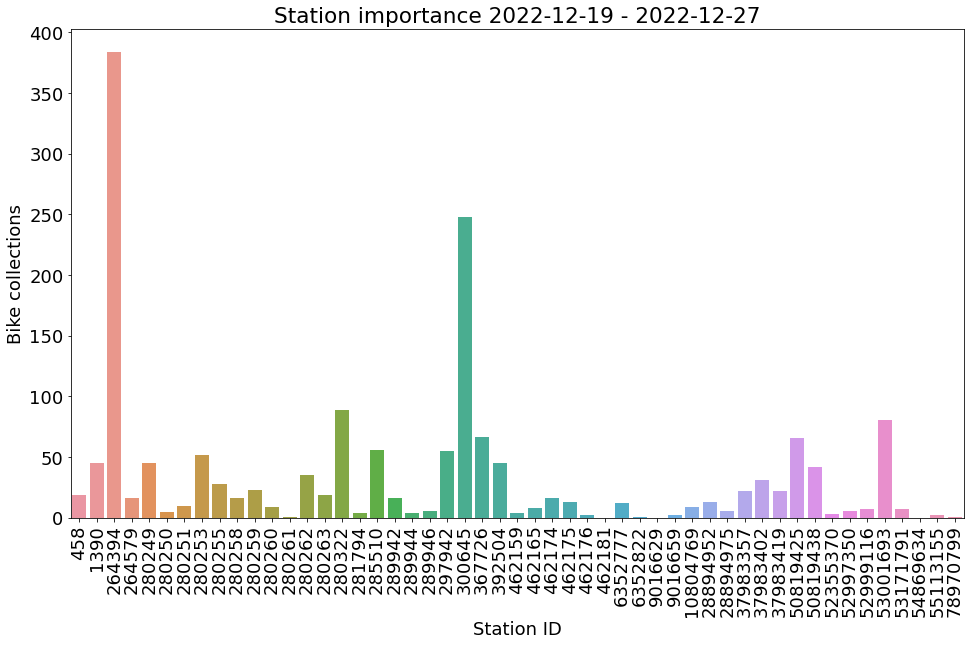

In [24]:
station_importance = x.loc[x.valid].groupby('uid').agg(
    {'collected': 'sum', 'returned': 'sum', 'timestamp_end': 'last', 'timestamp_start': 'first', 'lng': 'first', 'lat': 'first'}
).reset_index()
sns.barplot(x='uid', y='collected', data = station_importance)
plt.xticks(rotation=90)
plt.xlabel('Station ID')
plt.ylabel('Bike collections')
plt.title(f'Station importance {station_importance["timestamp_start"].dt.date.iloc[0]} - {station_importance["timestamp_end"].dt.date.iloc[0]}')
plt.show()

In [25]:
station_importance

,uid,collected,returned,timestamp_end,timestamp_start,lng,lat
0,458,19,20,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.402725,49.007126
1,1390,45,46,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.395077,49.008694
2,264394,384,465,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.400361,48.994617
3,264579,16,17,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.453540,49.027000
4,280249,45,44,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.395102,49.010834
5,280250,5,5,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.393548,48.997704
6,280251,10,10,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.388213,49.010063
7,280253,52,54,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.423453,49.011246
8,280255,28,27,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.431732,49.006073
9,280258,16,14,2022-12-27 13:43:04.326,2022-12-19 09:24:06.679,8.394901,49.005444


Mapa do adaptacji z danymi geograficznymi (OSM?)

In [41]:
px.set_mapbox_access_token(open(".mapbox_token").read())


fig = px.scatter_mapbox(station_importance, lat='lat',
                    lon='lng',
                    size='collected')
fig.update_layout(mapbox_style = "open-street-map")

fig.show()
